In [1]:
from google.colab import files
uploaded = files.upload()

Saving ride_sharing.csv to ride_sharing.csv


In [2]:
import pandas as pd # Data processing
import numpy as np  # Linear algebra

import matplotlib.pyplot as plt # Data visualization
import seaborn as sns  # Data visualization 
from wordcloud import WordCloud # Visualizing words and string

import re  # Regular expressions

In [3]:
# read our dataset.
data = pd.read_csv("ride_sharing.csv")
data.head()

,Unnamed: 0,duration,station_A_id,station_A_name,station_B_id,station_B_name,bike_id,user_type,user_birth_year,user_gender
0,0,12 minutes,81,Berry St at 4th St,323,Broadway at Kearny,5480,2,1959,Male
1,1,24 minutes,3,Powell St BART Station (Market St at 4th St),118,Eureka Valley Recreation Center,5193,2,1965,Male
2,2,8 minutes,67,San Francisco Caltrain Station 2 (Townsend St...,23,The Embarcadero at Steuart St,3652,3,1993,Male
3,3,4 minutes,16,Steuart St at Market St,28,The Embarcadero at Bryant St,1883,1,1979,Male
4,4,11 minutes,22,Howard St at Beale St,350,8th St at Brannan St,4626,2,1994,Male


In [4]:
# A bit more information and summarize of our dataset.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25760 entries, 0 to 25759
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       25760 non-null  int64 
 1   duration         25760 non-null  object
 2   station_A_id     25760 non-null  int64 
 3   station_A_name   25760 non-null  object
 4   station_B_id     25760 non-null  int64 
 5   station_B_name   25760 non-null  object
 6   bike_id          25760 non-null  int64 
 7   user_type        25760 non-null  int64 
 8   user_birth_year  25760 non-null  int64 
 9   user_gender      25760 non-null  object
dtypes: int64(6), object(4)
memory usage: 2.0+ MB


As we can observe, We've 25769 entries, one row for each ride sharing sample and 10 columns.<br>And it seems we have no missingness.

# ***Data cleaning***.
### ***Datatype constrains.***
We've to make sure that our columns are in correct datatype.

The data type of ***duration column*** is object, but it contains ***numerical data***, which represents ***bicycle ride sharing duration time in minutes***.
So, we have to convert it into numeric to ***avoid  misleading results*** when trying to extract some statistical summaries, as mathematical operations such as summing and multiplication lead to string concatenation, not numerical outputs. But first let's strip "minutes" from the column in order to make sure pandas reads it as numerical.

In [5]:
# Strip duration of minutes and Convert it  to integer.
data["duration"] = data["duration"].str.strip("minutes").astype("int")
data["duration"].mean()

11.389052795031056

11 minutes is really not bad for an average ride duration in a city like San-Francisco.

The user_type column contains information on whether a user is taking a free ride and takes on the following values: 
*   1 - for free riders.
*   2 - for pay per ride.
*   3 - for monthly subscribers.

But the data type of user_type column is int64, we have to convert it to category, as the summary statistics are much more aligned with that of a categorical variable, discussing the number of observations, number of unique values, most frequent category instead of mean and standard deviation.

In [6]:
# category= lambda x: x.astype("category")
data["user_type"] = data["user_type"].astype("category")

For the same reasons, we have to convert user_gender to category

In [7]:
data["user_gender"] = data["user_gender"].astype("category")

Let's convet user_birth_year to datatime instead of object type. <br> Luckily, Python has specific data type objects for various data types that you're probably familiar with by now. This makes it much easier to manipulate these various data types in Python.

In [8]:
#data["user_birth_year"] = pd.to_datetime(data["user_birth_year"])

'Unnamed: 0 column does not contain any useful or certain information, so we'll drop it due to memory space reasons.

In [9]:
data.drop('Unnamed: 0', axis=1, inplace=True)

### ***check for duplicates.***
A new update to the data pipeline feeding into ride_sharing has added the ride_id column, which represents a unique identifier for each ride.

The update however coincided with radically shorter average ride duration times and irregular user birth dates set in the future. Most importantly, the number of rides taken has increased by 20% overnight, leading you to think there might be both complete and incomplete duplicates in the ride_sharing DataFrame. <br> Let's confirm this suspicion by finding those duplicates.

In [10]:
# Find duplicates
subset = ['duration', 'bike_id', 'station_A_id', 'user_type', 'user_birth_year', 'user_gender']
duplicates = data.duplicated(subset = subset, keep = False)
# Sort your duplicated rides
duplicated_rides = data[duplicates].sort_values('bike_id')
duplicated_rides

,duration,station_A_id,station_A_name,station_B_id,station_B_name,bike_id,user_type,user_birth_year,user_gender
15217,17,22,Howard St at Beale St,102,Irwin St at 8th St,492,3,1961,Female
9696,17,22,Howard St at Beale St,102,Irwin St at 8th St,492,3,1961,Female
566,9,81,Berry St at 4th St,81,Berry St at 4th St,1225,2,1993,Male
604,9,81,Berry St at 4th St,81,Berry St at 4th St,1225,2,1993,Male
394,9,67,San Francisco Caltrain Station 2 (Townsend St...,27,Beale St at Harrison St,2039,3,1991,Male
3380,9,67,San Francisco Caltrain Station 2 (Townsend St...,23,The Embarcadero at Steuart St,2039,3,1991,Male
19053,3,22,Howard St at Beale St,25,Howard St at 2nd St,4317,2,1984,Male
20015,3,22,Howard St at Beale St,11,Davis St at Jackson St,4317,2,1984,Male
18303,10,30,San Francisco Caltrain (Townsend St at 4th St),6,The Embarcadero at Sansome St,4442,1,1967,Male
7610,10,30,San Francisco Caltrain (Townsend St at 4th St),6,The Embarcadero at Sansome St,4442,1,1967,Male


In [11]:
duplicated_rides.shape

(42, 9)

We've alot of samples that are ***completely duplicates*** (42 samples), and some samples are duplicated with ***small discrepancies*** across the columns.
<br> For completely duplicates, simply we are goning to drop it. 

In [12]:
# drop samples that are completely duplicates
data = data.drop_duplicates(subset)

For duplicates with ***small discrepancies*** we can use a statistical measure to combine each set of duplicated values. 

In [13]:
#subset= ['station_A_id', 'station_B_id', 'bike_id', 'user_type', 'user_gender']
# Create statistics dictionary for aggregation function
#statistics = {'user_birth_year': 'min', 'duration': 'mean'}

# Group by subset column and compute new statistics
#data = data.groupby(subset).agg(statistics).reset_index()

# ***Exploratory data analysis.***

Let's set a global style for our visualizations.

In [14]:
sns.set(font_scale=1.5, rc={"figure.figsize":(8,6)})
sns.set_style("ticks")

In [15]:
data.user_type.value_counts()

2    12958
3     6496
1     6285
Name: user_type, dtype: int64

*   1 - for free riders.
*   2 - for pay per ride.
*   3 - for monthly subscribers.
<br> Let's convert this into a nicer looking chart.

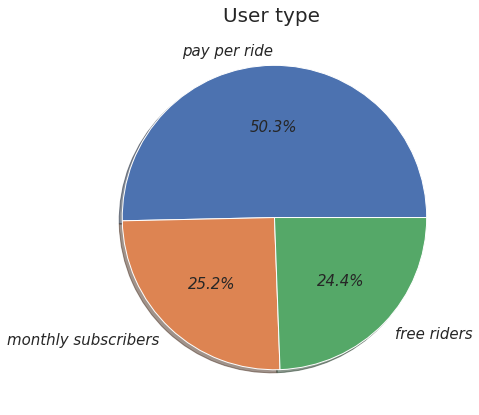

In [ ]:
plt.figure(figsize=(10,7))
plt.pie(data["user_type"].value_counts(), autopct="%1.1f%%", 
        labels=["pay per ride", "monthly subscribers", "free riders"], 
        textprops={"fontsize":15, "style":"italic"}, shadow=True)
plt.title("User type ", fontsize=20)

plt.show()

In [16]:
gender= data.user_gender.value_counts(normalize=True)* 100
round(gender, 1)

Male      75.2
Female    23.4
Other      1.4
Name: user_gender, dtype: float64

Just 1.4% from our samples that have not been recorded truely, So we'll replace this with the 

In [18]:
#data.loc[data['user_gender'] == 'Other', "user_gender"] = "Male"
data["user_gender"]= data["user_gender"].replace('Other', "Male")

Now, let's visualize it, for better intution.

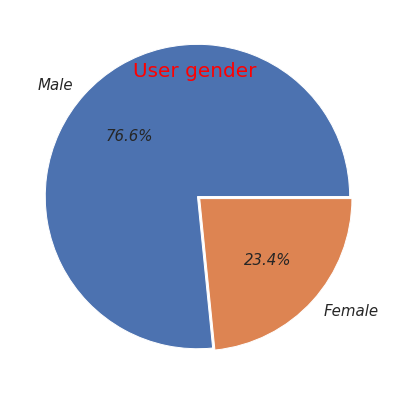

In [19]:
plt.figure(figsize=(10,7))
plt.pie(data["user_gender"].value_counts(), autopct="%1.1f%%", 
        labels=["Male", "Female"], 
        textprops={"fontsize":15, "style":"italic"}, 
        explode=[0, 0.02])
plt.title("User gender ", fontsize=20, color="red", y=0.8)

plt.show()

## ***Does gender affect on user behaviour or type ?***

In [21]:
user= pd.DataFrame(data.groupby(by="user_gender").user_type.value_counts(normalize =True)*100)
round(user, 1)

user_type
user_gender             
Female      2       50.5
            3       25.2
            1       24.3
Male        2       50.3
            3       25.3
            1       24.4

It seems user gender does not have any effects on user type. As the rates are the same.
<br> But let;s convert this table into a nicer lookingn chart.

In [65]:
def barPerc(df,xVar,ax):
    numX=len([x for x in df[xVar].unique() if x==x])
    bars = ax.patches
    for ind in range(numX):
        hueBars=bars[ind:][::numX]
        total = sum([x.get_height() for x in hueBars])
        for bar in hueBars:
            ax.text(bar.get_x() + bar.get_width()/2.,
                    bar.get_height(),
                    f'{bar.get_height()/total:.1%}',
                    ha="center",va="bottom")

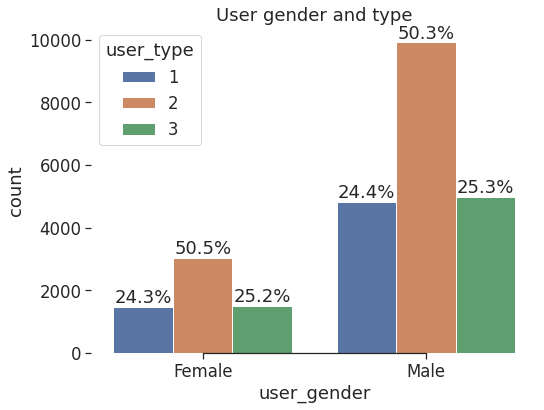

In [66]:
ax= sns.countplot(data=data, x="user_gender", hue="user_type")
plt.title("User gender and type")
sns.despine(trim=True, left=True)
barPerc(data, "user_gender",ax)


In [67]:
print("No. 1est station", data.station_A_name.nunique(), "\n")
data.station_A_name.unique()

No. 1est station 9 



array(['Berry St at 4th St',
       'Powell St BART Station (Market St at 4th St)',
       'San Francisco Caltrain Station 2  (Townsend St at 4th St)',
       'Steuart St at Market St', 'Howard St at Beale St',
       'San Francisco Caltrain (Townsend St at 4th St)',
       'San Francisco Ferry Building (Harry Bridges Plaza)',
       'Montgomery St BART Station (Market St at 2nd St)',
       'Powell St BART Station (Market St at 5th St)'], dtype=object)

In [ ]:
print("No. 1est station", data.station_A_id.nunique(), "\n")
data.station_A_id.unique()

No. 1est station 9 



array([81,  3, 67, 16, 22, 30, 15, 21,  5])

Each ***statiion_A_name  has a different id***, and ***since we have 9 places and 9 ids***,then there is ***no problem with statiion_A_name***.
<br> Our dataset is already from ***San Francisco***, So having San Francisico in each station A name does not add value or certain information. So, we'll drop it.

In [68]:
data["station_A_name"] = data["station_A_name"].str.strip("San Francisco")

***'Powell St BART Station (Market St at 4th St)'*** <br>and ***'Powell St BART Station (Market St at 5th St)'*** <br> are ***two different stations*** with ***very small differencies in street number 4th and 5th***.<br> So let's collabse them into one category or one station. 

In [69]:
# clean the straing in stations names Using regular expression 

def clean_train_data(x):
    text = x
    text = text.lower()
    text = re.sub('\[.*?\]', '', text) # remove square brackets
    text = re.sub('st at \d+\w+ st', '', text) # remove st and words containing numbers
    text = re.sub('st', '', text) # remove st 
    text = re.sub("[()]","", text) # remove parentheses
    return text

In [70]:
data['station_A_name'] = data.station_A_name.apply(lambda x : clean_train_data(x))

Let's visualize it.

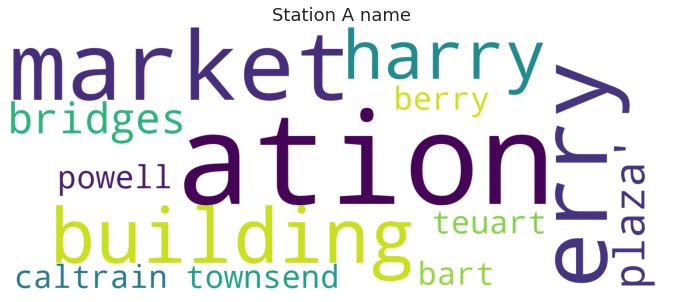

In [72]:
plt.figure(figsize = (12, 8))

wordcloud = WordCloud(width = 1500, height = 600, background_color ='white')
 
stattionA= data["station_A_name"].dropna().values
wordcloud.generate(str(stattionA))
# plot the WordCloud image                      
plt.title("Station A name")
plt.imshow(wordcloud)
plt.axis("off")
 
plt.show()

Let's visualize it with ather way, but this time with the ***statiion id***, but remember we have collabseed places with station id 3 and 5 into one.

In [73]:
data["station_A_id"]= data["station_A_id"].replace(3, 5)

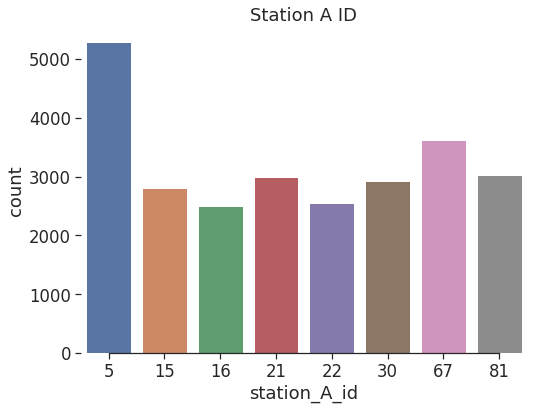

In [76]:
sns.countplot(data=data, x="station_A_id")
sns.despine(trim=True, left=True)
plt.title("Station A ID")
plt.show()

We've 

In [ ]:
print("No. 2ed station", data.station_B_name.nunique(), "\n")
data.station_B_name.unique()

No. 2ed station 152 



array(['Broadway at Kearny', 'Eureka Valley Recreation Center',
       'The Embarcadero at Steuart St', 'The Embarcadero at Bryant St',
       '8th St at Brannan St', 'The Embarcadero at Sansome St',
       '17th St at Dolores St', '14th St at Mission St',
       'Steuart St at Market St', 'Victoria Manalo Draves Park',
       '1st St at Folsom St', 'Beale St at Harrison St',
       '23rd St at Tennessee St', 'Laguna St at Hayes St',
       '5th St at Folsom', '19th St at Mission St',
       'Davis St at Jackson St',
       'San Francisco City Hall (Polk St at Grove St)',
       'Market St at 10th St', 'China Basin St at 3rd St',
       'Valencia St at Clinton Park',
       'Mechanics Monument Plaza (Market St at Bush St)',
       '17th St at Valencia St', '4th St at Mission Bay Blvd S',
       'Jones St at Post St', 'Howard St at 8th St',
       'Mississippi St at 17th St',
       'San Francisco Ferry Building (Harry Bridges Plaza)',
       'Irwin St at 8th St', 'McCoppin St at Valenc

In [ ]:
print("No. 1est station", data.station_B_id.nunique(), "\n")
data.station_B_id.unique()

No. 1est station 152 



array([323, 118,  23,  28, 350,   6, 107,  97,  16,  62,  26,  27, 355,
        74, 321, 122,  11,  42,  58, 364, 356,  20, 109,  93, 370,  61,
       116,  15, 102,  76,  50, 343, 130,  80,  64,  41,   4,  81,  78,
         9,  70,  55, 377,  90,  72, 365,  47,  67, 139,  88,  77,  75,
        60, 345,  52, 121,  21,  85, 112, 125, 134,  73, 223,  33, 115,
         5, 114,  92,  37, 126,  86,  10, 101, 136,  49,  43,   3,  53,
       104, 100, 144, 284,  87,  66, 142, 371,  30,  91,  79,  19, 120,
        14, 131, 324,  39,  95, 375,   8, 336,  44,  22, 110,  24, 285,
        63,  36,  84,  96,  89,  17, 137, 119,  31,  34, 349, 133,  54,
        56, 127, 383,  59,  13, 368,  25, 141, 123, 363, 106,  99, 360,
       124, 369, 129, 105, 145, 361, 132, 113,  71, 146, 380, 381, 373,
       358,  29, 362, 108, 147, 138, 359, 140,  98])

Doing the same for station B name.

In [77]:
data['station_B_name'] = data.station_B_name.apply(lambda x : clean_train_data(x))

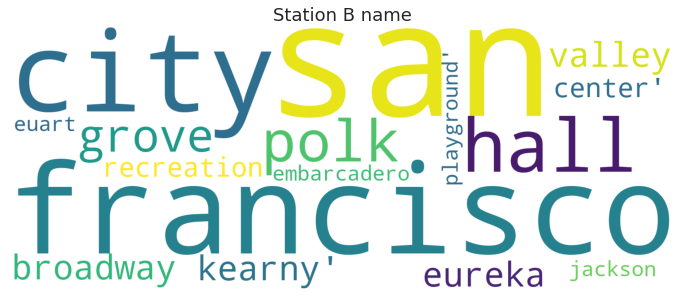

In [78]:
plt.figure(figsize = (12, 8))

wordcloud = WordCloud(width = 1500, height = 600, background_color ='white')
 
stattionB= data["station_B_name"].dropna().values
wordcloud.generate(str(stattionB))
# plot the WordCloud image                      
plt.title("Station B name")
plt.imshow(wordcloud)
plt.axis("off")
 
plt.show()

In [ ]:
stations= pd.DataFrame(data.groupby(by="station_A_id").station_B_id.value_counts(normalize=True) * 100)
stations= round(stations, 1)
stations

station_B_id
station_A_id station_B_id              
3            58                     6.3
             47                     6.1
             30                     4.9
             67                     3.7
             81                     2.4
...                                 ...
81           358                    0.0
             361                    0.0
             362                    0.0
             369                    0.0
             381                    0.0

[1235 rows x 1 columns]

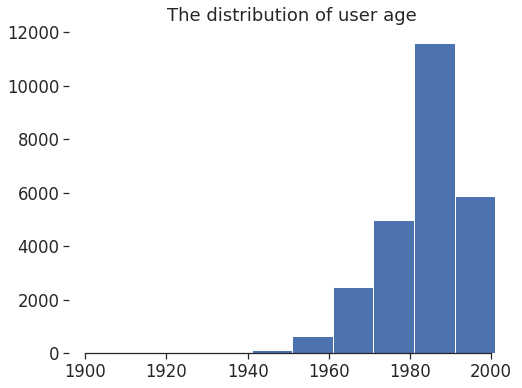

In [81]:
plt.hist(data=data, x="user_birth_year")
sns.despine(trim=True, left=True)
plt.title("The distribution of user age")
plt.show()

As we can observe the distribution is left-skewed, which means that we have more old uers than younger.